In [2]:
import json
import numpy as np
import pandas as pd
import os
import math

In [3]:
def load_scores(mat_path, matches_path):
    n_queries = len(json.load(open(matches_path)))
    mat = np.fromfile(mat_path, dtype=np.float32)[4:]
    n_targets = len(mat) // n_queries
    return mat.reshape(n_queries, n_targets)    

In [4]:
def load_files(match_path, distractor_mat_path, prob_mat_path, features_path):
    prob_features = json.load(open(features_path))
    distractor_mat = load_scores(distractor_mat_path, match_path)
    prob_mat = load_scores(prob_mat_path, match_path)
    np.fill_diagonal(prob_mat, prob_mat.min() - 1) # self dist is not interesting!
    prob_ids = np.array(prob_features['id'])
    return prob_mat, distractor_mat, prob_ids

In [5]:
def dist_fuse(mat_1, mat_2):
    return (mat_1 + mat_2) / 2

In [6]:
def top1(prob_mat, distractor_mat, prob_ids):
    """ 
        is the target id in the top 1 (not including self image)
        (prob_mat assuming diag is nan)
        prob_ids are a ground truth of ids ordered probmat entries
    """
    
    out_max = np.max(distractor_mat, axis=1) # best out of distractor set
    out_max_labels = np.argmax(distractor_mat, axis=1) # best out of distractor set
    
    np.fill_diagonal(prob_mat, prob_mat.min() - 1)
    tot_mat = np.concatenate((prob_mat, out_max.reshape(prob_mat.shape[0], 1)), axis=1) # working with a small matrix :)
    
    top_scores = np.max(tot_mat, axis=1)
    top_labels = np.argmax(tot_mat, axis=1) # indices
    top_labels = np.where(top_labels < len(prob_ids), top_labels, -1) # safe indices
    top_labels = np.where(top_labels > -1, prob_ids[top_labels], out_max_labels) # labels
    
    return top_labels, top_scores

In [7]:
def topk(prob_mat, distractor_mat, prob_ids, k):
    """ 
        is the target id in the top 1 (not including self image)
        (prob_mat assuming diag is nan)
        prob_ids are a ground truth of ids ordered probmat entries
    """
    
    tot_mat = np.concatenate((prob_mat, distractor_mat), axis=1) # working with a small matrix :)
    out_max_k = -np.partition(-tot_mat, k, axis=1)[:, :k] # best out of distractor set
    out_max_labels_k = np.argpartition(-tot_mat, k, axis=1)[:, :k] # best out of distractor set
    safe_indices = np.where(out_max_labels_k < len(prob_ids), out_max_labels_k, -1)
    out_max_labels_k = np.where(out_max_labels_k < len(prob_ids), prob_ids[safe_indices], out_max_labels_k)
    
    return out_max_labels_k, out_max_k

In [8]:
def rank1_(prob_mat, distractor_mat, prob_ids):
    """ 
        is the target id in the top 1 (not including self image)
        (prob_mat assuming diag is nan)
        prob_ids are a ground truth of ids ordered probmat entries
    """
    
    out_max = np.max(distractor_mat, axis=1) # best out of distractor set
    tot_mat = np.concatenate((prob_mat, out_max.reshape(3506, 1)), axis=1) # working with a small matrix :)
    n_probs = prob_mat.shape[1]
    inf_ = tot_mat.min() - 1
    score = 0
    n_query = 0 
    for query_id in set(prob_ids):
        # probes from iden
        row_mask = list((query_id == prob_ids))
        curr_id_mat = tot_mat[row_mask, :]
        
        n_id_probs, n_probs_and_one_other = curr_id_mat.shape
        query_indices = np.argwhere(row_mask).T[0]
        for row_i, col_i in enumerate(query_indices):
            # nullify all other cols from indices
            col_mask = row_mask.copy()
            col_mask[col_i] = False
            col_mask.append(False)

            other_probs_sub = curr_id_mat[: , col_mask].copy()
            curr_id_mat[: , col_mask] = inf_

            # calc hits
            top_hits = np.delete(np.argmax(curr_id_mat, axis=1), row_i ,0)
            top_id = np.where(top_hits < n_probs, top_hits, 0)
            top_id = np.where(top_hits < n_probs, prob_ids[top_id], 'NaN')
            score += sum(top_id == query_id)
            n_query += len(top_id)

            # get them back
            curr_id_mat[:, col_mask] = other_probs_sub
            
    return score/n_query

In [9]:
def open_set_label_and_score(prob_mat, distractor_mat, prob_ids):
    """
         What is the 2nd iden for the prob if he is not in set?
         What is it's score?
    """
    
    indexes = np.unique(prob_ids, return_index=True)[1]  # ids sorted by apperance
    id_set = [prob_ids[index] for index in sorted(indexes)]
    res_label = []
    res_score = []
    inf_ = min(distractor_mat.min(), prob_mat.min()) - 1
    for curr_id in id_set:
        # nullify all query cols from indices
        row_mask = list((curr_id == prob_ids))
        curr_prob_mat = prob_mat[row_mask, :].copy()
        curr_prob_mat[: , row_mask] = inf_
        
        label, scores = top1(curr_prob_mat, distractor_mat[row_mask, :], prob_ids)
        res_label.extend(label)
        res_score.extend(scores)
    return np.array(res_label), np.array(res_score)

In [10]:
def open_set_label_and_score_topk(prob_mat, distractor_mat, prob_ids):
    """
         What is the 2nd iden for the prob if he is not in set?
         What is it's score?
    """
    
    indexes = np.unique(prob_ids, return_index=True)[1]  # ids sorted by apperance
    id_set = [prob_ids[index] for index in sorted(indexes)]
    res_label = []
    res_score = []
    inf_ = min(distractor_mat.min(), prob_mat.min()) - 1
    for curr_id in id_set:
        # nullify all query cols from indices
        row_mask = list((curr_id == prob_ids))
        curr_prob_mat = prob_mat[row_mask, :].copy()
        curr_prob_mat[: , row_mask] = inf_
        
        label, scores = topk(curr_prob_mat, distractor_mat[row_mask, :], prob_ids, 3)
        res_label.append(label)
        res_score.append(scores)
    return np.vstack(res_label), np.vstack(res_score)

In [11]:
def model_agreement(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids):
    open_set_k_labels_0, open_set_k_scores_0  = open_set_label_and_score_topk(prob_mat_0, distractor_mat_0, prob_ids)
    open_set_k_labels_1, open_set_k_scores_1 = open_set_label_and_score_topk(prob_mat_1, distractor_mat_1, prob_ids)

    a = 0
    for row_0, row_1 in zip(open_set_k_labels_0, open_set_k_labels_1):
        a+= (len(np.intersect1d(row_0, row_1)) > 0)
    b = len(prob_ids)
    print('\n any(2nd,3rd,4th) iden Corr=%0.1f%% \n' % (100.0*a / b) )

In [117]:
def fuse_models(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids):
    rank1_0 = rank1_(prob_mat_0, distractor_mat_0, prob_ids)
    rank1_1 = rank1_(prob_mat_1, distractor_mat_1, prob_ids)
    rank1_fuse = rank1_(dist_fuse(prob_mat_0,prob_mat_1), dist_fuse(distractor_mat_0, distractor_mat_1), prob_ids)
    
    print('Rank-1:\n model0:{} \n model1:{} \n mean_fuse:{}'.format(rank1_0, rank1_1, rank1_fuse))
    
    top1_labels_0, top1_scores_0 = top1(prob_mat_0, distractor_mat_0, prob_ids)
    top1_labels_1, top1_scores_1 = top1(prob_mat_1, distractor_mat_1, prob_ids)

    open_set_1st_labels_0, open_set_1st_scores_0  = open_set_label_and_score(prob_mat_0, distractor_mat_0, prob_ids)
    open_set_1st_labels_1, open_set_1st_scores_1 = open_set_label_and_score(prob_mat_1, distractor_mat_1, prob_ids)

    model_agreement(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids)
    
    a = np.sum((open_set_1st_labels_0 == open_set_1st_labels_1))
    b = len(prob_ids)
    print('\n 2nd iden Corr=%0.1f%% \n' % (100.0*a / b) )

    target_FTRS = [0.0001, 0.01, 0.1, 0.2, 0.3]
    thresholds = np.unique(np.concatenate((top1_scores_0,top1_scores_1,
                                              open_set_1st_scores_0,open_set_1st_scores_1)))

    models_agree = (open_set_1st_labels_0 == open_set_1st_labels_1)
    FTRs = [np.sum(models_agree & (open_set_1st_scores_0 > TH) & (open_set_1st_scores_1 > TH)) / b
            for TH in thresholds]
    
    mod_0_corr = (top1_labels_0 == prob_ids)
    mod_1_corr = (top1_labels_1 == prob_ids)
    TTRs = [np.sum( (top1_scores_0 > TH) &
                    (top1_scores_1 > TH) &
                     mod_0_corr &
                     mod_1_corr ) / b for TH, FTR in zip(thresholds, FTRs)]

    for target_FTR in target_FTRS:
        if (FTRs[0] <= target_FTR):
            print('FTR=%0.1f%%, TTR=%0.1f%%' % (target_FTR * 100, TTRs[0] * 100))
            continue
        for TH, FTR, TTR in zip(thresholds, FTRs, TTRs):
            if math.isclose(FTR, target_FTR, abs_tol = 0.001):
                print('FTR=%0.1f%%, TTR=%0.1f%%' % (FTR * 100, TTR * 100))
                break
        
    return np.array(thresholds), np.array(FTRs), np.array(TTRs)

In [24]:
# baseline
match_path = "results/baseline_0/matches_facescrub_megaface_images_base_0_1000000_1.json"
distractor_mat_path = "results/baseline_0/otherFiles/facescrub_megaface_images_base_0_1000000_1.bin"
prob_mat_path = "results/baseline_0/otherFiles/facescrub_facescrub_base_0.bin"
features_path = "results/baseline_0/otherFiles/facescrub_features_base_0"

prob_mat_0, distractor_mat_0, prob_ids = load_files(match_path, distractor_mat_path, prob_mat_path, features_path)

match_path = "results/baseline_1/matches_facescrub_megaface_images_base_1_1000000_1.json"
distractor_mat_path = "results/baseline_1/otherFiles/facescrub_megaface_images_base_1_1000000_1.bin"
prob_mat_path = "results/baseline_1/otherFiles/facescrub_facescrub_base_1.bin"
features_path = "results/baseline_1/otherFiles/facescrub_features_base_1"

prob_mat_1, distractor_mat_1, prob_ids = load_files(match_path, distractor_mat_path, prob_mat_path, features_path)
baseline_thresholds, baseline_FTRs, baseline_TTR = fuse_models(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids)

Rank-1:
 model0:0.9605785854746539 
 model1:0.9650261973578282 
 mean_fuse:0.9690448852463344

 any(2nd,3rd,4th) iden Corr=70.9% 


 2nd iden Corr=28.1% 

FTR=0.1%, TTR=98.8%
FTR=1.0%, TTR=99.5%


In [25]:
# pearson.5
match_path = "results/pearson.5_0/matches_facescrub_megaface_images_pearson_1000000_1.json"
distractor_mat_path = "results/pearson.5_0/otherFiles/facescrub_megaface_images_pearson_1000000_1.bin"
prob_mat_path = "results/pearson.5_0/otherFiles/facescrub_facescrub_pearson.bin"
features_path = "results/pearson.5_0/otherFiles/facescrub_features_pearson"

prob_mat_0, distractor_mat_0, prob_ids = load_files(match_path, distractor_mat_path, prob_mat_path, features_path)

match_path = "results/pearson.5_1/matches_facescrub_megaface_images_pearson_1000000_1.json"
distractor_mat_path = "results/pearson.5_1/otherFiles/facescrub_megaface_images_pearson_1000000_1.bin"
prob_mat_path = "results/pearson.5_1/otherFiles/facescrub_facescrub_pearson.bin"
features_path = "results/pearson.5_1/otherFiles/facescrub_features_pearson"

prob_mat_1, distractor_mat_1, prob_ids = load_files(match_path, distractor_mat_path, prob_mat_path, features_path)
p5_thresholds, p5_FTRs, p5_TTR = fuse_models(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids)

Rank-1:
 model0:0.9564939092792757 
 model1:0.9583481807023796 
 mean_fuse:0.9668210793047471

 any(2nd,3rd,4th) iden Corr=51.8% 


 2nd iden Corr=18.3% 

FTR=0.1%, TTR=99.2%
FTR=1.1%, TTR=99.5%
FTR=10.0%, TTR=99.7%


In [26]:
# pearson.75
match_path = "results/pearson.75_0/matches_facescrub_megaface_images_pearson_1000000_1.json"
distractor_mat_path = "results/pearson.75_0/otherFiles/facescrub_megaface_images_pearson_1000000_1.bin"
prob_mat_path = "results/pearson.75_0/otherFiles/facescrub_facescrub_pearson.bin"
features_path = "results/pearson.75_0/otherFiles/facescrub_features_pearson"

prob_mat_0, distractor_mat_0, prob_ids = load_files(match_path, distractor_mat_path, prob_mat_path, features_path)

match_path = "results/pearson.75_1/matches_facescrub_megaface_images_pearson_1000000_1.json"
distractor_mat_path = "results/pearson.75_1/otherFiles/facescrub_megaface_images_pearson_1000000_1.bin"
prob_mat_path = "results/pearson.75_1/otherFiles/facescrub_facescrub_pearson.bin"
features_path = "results/pearson.75_1/otherFiles/facescrub_features_pearson"

prob_mat_1, distractor_mat_1, prob_ids = load_files(match_path, distractor_mat_path, prob_mat_path, features_path)
p75_thresholds, p75_FTRs, p75_TTR = fuse_models(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids)

Rank-1:
 model0:0.9490042364493012 
 model1:0.9436855789154162 
 mean_fuse:0.9628551820617387

 any(2nd,3rd,4th) iden Corr=30.9% 


 2nd iden Corr=9.4% 

FTR=0.1%, TTR=99.1%
FTR=1.1%, TTR=99.5%


In [21]:
# pearson.9
match_path = "results/pearson.9_0/matches_facescrub_megaface_images_pearson_1000000_1.json"
distractor_mat_path = "results/pearson.9_0/otherFiles/facescrub_megaface_images_pearson_1000000_1.bin"
prob_mat_path = "results/pearson.9_0/otherFiles/facescrub_facescrub_pearson.bin"
features_path = "results/pearson.9_0/otherFiles/facescrub_features_pearson"

prob_mat_0, distractor_mat_0, prob_ids = load_files(match_path, distractor_mat_path, prob_mat_path, features_path)

match_path = "results/pearson.9_1/matches_facescrub_megaface_images_pearson_1000000_1.json"
distractor_mat_path = "results/pearson.9_1/otherFiles/facescrub_megaface_images_pearson_1000000_1.bin"
prob_mat_path = "results/pearson.9_1/otherFiles/facescrub_facescrub_pearson.bin"
features_path = "results/pearson.9_1/otherFiles/facescrub_features_pearson"

prob_mat_1, distractor_mat_1, prob_ids = load_files(match_path, distractor_mat_path, prob_mat_path, features_path)
p9_thresholds, p9_FTRs, p9_TTR = fuse_models(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids)

Rank-1:
 model0:0.9089097411938605 
 model1:0.9263174565467 
 mean_fuse:0.9484367370102018

 any(2nd,3rd,4th) iden Corr=17.9% 


 2nd iden Corr=5.0% 

FTR=0.1%, TTR=98.9%
FTR=0.9%, TTR=99.3%


In [107]:
# mean.1
match_path = "results/mean.1_0/matches_facescrub_megaface_images_mean_1000000_1.json"
distractor_mat_path = "results/mean.1_0/otherFiles/facescrub_megaface_images_mean_1000000_1.bin"
prob_mat_path = "results/mean.1_0/otherFiles/facescrub_facescrub_mean.bin"
features_path = "results/mean.1_0/otherFiles/facescrub_features_mean"

prob_mat_0, distractor_mat_0, prob_ids = load_files(match_path, distractor_mat_path, prob_mat_path, features_path)

match_path = "results/mean.1_1/matches_facescrub_megaface_images_mean_1000000_1.json"
distractor_mat_path = "results/mean.1_1/otherFiles/facescrub_megaface_images_mean_1000000_1.bin"
prob_mat_path = "results/mean.1_1/otherFiles/facescrub_facescrub_mean.bin"
features_path = "results/mean.1_1/otherFiles/facescrub_features_mean"

prob_mat_1, distractor_mat_1, prob_ids = load_files(match_path, distractor_mat_path, prob_mat_path, features_path)
m1_thresholds, m1_FTRs, m1_TTR = fuse_models(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids)

Rank-1:
 model0:0.9603674228926634 
 model1:0.959113645062095 
 mean_fuse:0.9667880851513112

 any(2nd,3rd,4th) iden Corr=62.2% 


 2nd iden Corr=23.7% 

FTR=0.1%, TTR=99.2%
FTR=1.1%, TTR=99.5%
FTR=10.1%, TTR=99.7%
FTR=20.1%, TTR=99.7%
FTR=30.0%, TTR=99.7%


In [108]:
# mean.25
match_path = "results/mean.25_0/matches_facescrub_megaface_images_mean_1000000_1.json"
distractor_mat_path = "results/mean.25_0/otherFiles/facescrub_megaface_images_mean_1000000_1.bin"
prob_mat_path = "results/mean.25_0/otherFiles/facescrub_facescrub_mean.bin"
features_path = "results/mean.25_0/otherFiles/facescrub_features_mean"

prob_mat_0, distractor_mat_0, prob_ids = load_files(match_path, distractor_mat_path, prob_mat_path, features_path)

match_path = "results/mean.25_1/matches_facescrub_megaface_images_mean_1000000_1.json"
distractor_mat_path = "results/mean.25_1/otherFiles/facescrub_megaface_images_mean_1000000_1.bin"
prob_mat_path = "results/mean.25_1/otherFiles/facescrub_facescrub_mean.bin"
features_path = "results/mean.25_1/otherFiles/facescrub_features_mean"

prob_mat_1, distractor_mat_1, prob_ids = load_files(match_path, distractor_mat_path, prob_mat_path, features_path)
m25_thresholds, m25_FTRs, m25_TTR = fuse_models(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids)

Rank-1:
 model0:0.9579720473532091 
 model1:0.9558010320571195 
 mean_fuse:0.9672566021301026

 any(2nd,3rd,4th) iden Corr=50.1% 


 2nd iden Corr=18.0% 

FTR=0.1%, TTR=98.9%
FTR=1.1%, TTR=99.5%
FTR=10.1%, TTR=99.7%
FTR=20.0%, TTR=99.7%
FTR=30.0%, TTR=99.7%


In [109]:
# mean.5
match_path = "results/mean.5_0/matches_facescrub_megaface_images_mean_1000000_1.json"
distractor_mat_path = "results/mean.5_0/otherFiles/facescrub_megaface_images_mean_1000000_1.bin"
prob_mat_path = "results/mean.5_0/otherFiles/facescrub_facescrub_mean.bin"
features_path = "results/mean.5_0/otherFiles/facescrub_features_mean"

prob_mat_0, distractor_mat_0, prob_ids = load_files(match_path, distractor_mat_path, prob_mat_path, features_path)

match_path = "results/mean.5_1/matches_facescrub_megaface_images_mean_1000000_1.json"
distractor_mat_path = "results/mean.5_1/otherFiles/facescrub_megaface_images_mean_1000000_1.bin"
prob_mat_path = "results/mean.5_1/otherFiles/facescrub_facescrub_mean.bin"
features_path = "results/mean.5_1/otherFiles/facescrub_features_mean"

prob_mat_1, distractor_mat_1, prob_ids = load_files(match_path, distractor_mat_path, prob_mat_path, features_path)
m5_thresholds, m5_FTRs, m5_TTR = fuse_models(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids)

Rank-1:
 model0:0.9469783954283301 
 model1:0.944464240936506 
 mean_fuse:0.9702326747700307

 any(2nd,3rd,4th) iden Corr=15.3% 


 2nd iden Corr=4.2% 

FTR=0.1%, TTR=99.3%
FTR=1.1%, TTR=99.6%
FTR=10.0%, TTR=99.7%
FTR=20.0%, TTR=99.7%
FTR=30.0%, TTR=99.7%


In [17]:
import matplotlib.pylab as plt
import matplotlib
%matplotlib inline

Text(0.5,1,'Open set DIR')

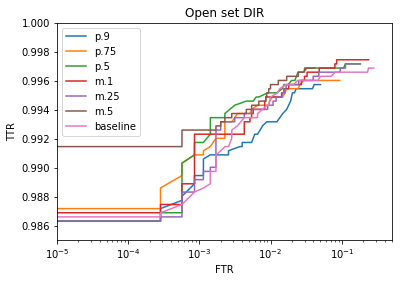

In [119]:
# TODO flip axis?
# TODO add a dash line for cieling?
plt.plot(p9_FTRs, p9_TTR, label='p.9')
plt.plot(p75_FTRs, p75_TTR, label='p.75')
plt.plot(p5_FTRs, p5_TTR, label='p.5')

plt.plot(m1_FTRs, m1_TTR, label='m.1')
plt.plot(m25_FTRs, m25_TTR, label='m.25')
plt.plot(m5_FTRs, m5_TTR, label='m.5')

plt.plot(baseline_FTRs, baseline_TTR, label='baseline')
plt.xlabel('FTR')
plt.ylabel('TTR')
plt.ylim([.985, 1])
plt.xscale('log')
plt.xlim([1e-5, .5])
plt.legend()
plt.title('Open set DIR')

No handles with labels found to put in legend.


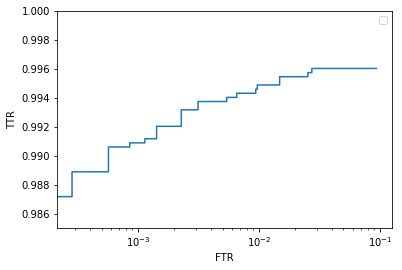

In [104]:
plt.plot(FTRs, TTRs)
plt.xlabel('FTR')
plt.ylabel('TTR')
plt.ylim([.985, 1])
plt.xscale('log')
plt.legend()